In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import datetime
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop



### Importing the data

In [173]:
user_cols = ['UserID','MovieID','Rating','Timestamp']
filename="./ratings.dat"
user_rating = pd.read_csv(filename, sep='::',names=user_cols, encoding='latin-1')
# user_rating.head()

item_cols = ['MovieID','Title','Genres']
filename="./movies.dat"
movies = pd.read_csv(filename, sep='::',names=item_cols, encoding='latin-1')
# movies.head()

final = user_rating.merge(movies, how='left', left_on='MovieID', right_on='MovieID')

#converting timestamp to date time 
final['Date']=final['Timestamp'].map(datetime.fromtimestamp).dt.date


# downsampling
# final=final.sample(frac=0.1)

## Save and load the data for time saving

In [172]:
# final.shape
# final.to_pickle('./final.pkl')
final=pd.read_pickle('./final.pkl')
final=final.iloc[0:100,:]

final.shape

(100, 7)

### Exploratory data analysis 

In [174]:
final.describe(include='all')
final.dtypes
final.isnull().sum()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Date
count,1.000188e+07,1.000187e+07,1.000187e+07,1.000188e+07,9996617,9996647,10001878
unique,NaN,NaN,NaN,NaN,10675,797,4638
top,NaN,NaN,NaN,NaN,Pulp Fiction (1994),Drama,2000-11-20
freq,NaN,NaN,NaN,NaN,34864,815083,64128
mean,3.586967e+04,4.119553e+03,4.002864e+03,1.032587e+09,NaN,NaN,NaN
std,2.058536e+04,8.937759e+03,6.323962e+06,1.159712e+08,NaN,NaN,NaN
min,1.000000e+00,1.000000e+00,-2.000000e+02,7.896520e+08,NaN,NaN,NaN
25%,1.812200e+04,6.480000e+02,3.000000e+00,9.467544e+08,NaN,NaN,NaN
50%,3.573900e+04,1.833000e+03,4.000000e+00,1.035425e+09,NaN,NaN,NaN
75%,5.360700e+04,3.624000e+03,4.000000e+00,1.126695e+09,NaN,NaN,NaN


UserID       float64
MovieID      float64
Rating       float64
Timestamp      int64
Title         object
Genres        object
Date          object
dtype: object

UserID          1
MovieID         8
Rating          4
Timestamp       0
Title        5261
Genres       5231
Date            0
dtype: int64

,UserID,MovieID,Rating,Timestamp
count,9.996604e+06,9.996604e+06,9.996604e+06,9.996604e+06
mean,3.586991e+04,4.115497e+03,4.004972e+03,1.032593e+09
std,2.058528e+04,8.930424e+03,6.325629e+06,1.159565e+08
min,1.000000e+00,1.000000e+00,-2.000000e+02,7.896520e+08
25%,1.812300e+04,6.480000e+02,3.000000e+00,9.467661e+08
50%,3.574000e+04,1.834000e+03,4.000000e+00,1.035426e+09
75%,5.360800e+04,3.624000e+03,4.000000e+00,1.126651e+09
max,7.156700e+04,6.513300e+04,1.000000e+10,1.231132e+09


<AxesSubplot:title={'center':'Raw data'}, xlabel='Rating'>

<AxesSubplot:title={'center':'After Cleaning Ratings'}, xlabel='Rating'>

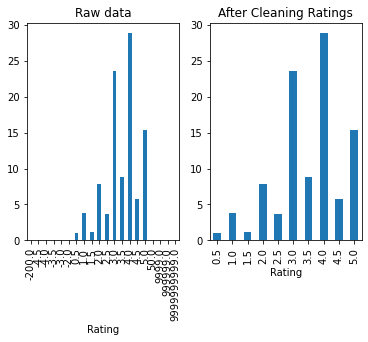

In [175]:
### Removing rows with nan in tile and genre
final.dropna(inplace=True)
final.describe()

### Checking the hisotgrma of Ratings
fig, axes = plt.subplots(nrows=1, ncols=2)
count_rates = final.groupby('Rating').count()
count_rates['perc_total']=round(count_rates['UserID']*100/count_rates['UserID'].sum(),1)
count_rates['perc_total'].plot.bar(title="Raw data",ax=axes[0])

### Removing rows with negative Rating and Ratings more than 5
final=final[(final.Rating<=5) & (final.Rating>=0)]
count_rates = final.groupby('Rating').count()
count_rates['perc_total']=round(count_rates['UserID']*100/count_rates['UserID'].sum(),1)
count_rates['perc_total'].plot.bar(title="After Cleaning Ratings",ax=axes[1])

### Changing the userID, MovieID into INT (currently float64)
final.UserID=final.UserID.astype(int)
final.MovieID=final.MovieID.astype(int)

### Removing duplicate ratings if any
### using DASK to reduce time

In [135]:
print("We have %d users"%final.UserID.nunique())
print("We have %d movies"%final.MovieID.nunique())

## using DASK to use multiple core
from dask import dataframe as dd
# final=final.sample(frac=0.01)
final_d = dd.from_pandas(final, npartitions=2)
ratings_df_d = final_d.groupby(['UserID','MovieID']).aggregate(np.max)
# ratings_df = final.groupby(['UserID','MovieID']).aggregate(np.max)
ratings_df_d.head()
print(len(ratings_df_d))
# print(len(ratings_df))
if (len(ratings_df_d) == final.shape[0]):
# if (len(ratings_df) == final.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")

We have 100 users
We have 100 movies


,,Rating,Timestamp,Title,Genres,Date
UserID,MovieID,,,,,
4007,2391,5.0,946341544,"Simple Plan, A (1998)",Crime|Drama|Thriller,1999-12-27
4105,2717,4.5,1135591943,Ghostbusters II (1989),Action|Comedy|Fantasy|Horror|Sci-Fi,2005-12-26
4538,3923,3.5,1086592200,Return of the Fly (1959),Horror|Sci-Fi,2004-06-07
7145,32,4.5,1056134831,12 Monkeys (Twelve Monkeys) (1995),Sci-Fi|Thriller,2003-06-20
8010,205,3.0,844937001,Unstrung Heroes (1995),Comedy|Drama,1996-10-10


100
there are no such cases where the user has rated the same movie twice.


## Creating one hot encoding for genres

In [176]:
# finding all availbale genres
final['Genres'] = final['Genres'].str.replace('|',' ')
all_genres=list(set(final.Genres.str.cat(sep=' ').split()))
final[all_genres]=0

# Adding one hot endodings
for genre in all_genres :
  final[genre] = final.apply(lambda row:int(genre in row.Genres), axis = 1)
final.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Date,War,Crime,Musical,...,Adventure,Comedy,Fantasy,Horror,listed),Western,(no,Thriller,Film-Noir,genres
0,1,122,5.0,838985046,Boomerang (1992),Comedy Romance,1996-08-02,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,185,5.0,838983525,"Net, The (1995)",Action Crime Thriller,1996-08-02,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,231,5.0,838983392,Dumb & Dumber (1994),Comedy,1996-08-02,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,292,5.0,838983421,Outbreak (1995),Action Drama Sci-Fi Thriller,1996-08-02,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,316,5.0,838983392,Stargate (1994),Action Adventure Sci-Fi,1996-08-02,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## List of top rated movies without considering the number of rates

In [137]:
top_movies_ID=final.groupby('Title')['Rating'].mean().sort_values(ascending=False)
top_movies_ID.head()

Title
Star Wars: Episode VI - Return of the Jedi (1983)    5.0
Fight Club (1999)                                    5.0
Mystery Science Theater 3000: The Movie (1996)       5.0
Harold and Maude (1971)                              5.0
Glengarry Glen Ross (1992)                           5.0
Name: Rating, dtype: float64

## List of top rated movies, considering the count of rates (Removing movies less than 20 rates)

In [185]:
avg_movie_rating = pd.DataFrame(final.groupby('Title')['Rating'].agg(['mean','count']))
min_no_rates=20
avg_movie_rating=avg_movie_rating[avg_movie_rating['count']>min_no_rates].sort_values(by='mean',ascending=False)
avg_movie_rating.head()

,mean,count
Title,,
"Shawshank Redemption, The (1994)",4.457238,31126
"Godfather, The (1972)",4.415085,19814
"Usual Suspects, The (1995)",4.367142,24037
Schindler's List (1993),4.363483,25777
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.321966,3255


## finding the movie with maximum consecetive ratings

In [139]:
 from datetime import timedelta
 sc=lambda x: sum(x.sort_values().diff()==timedelta(days = 1))
 rating_diff_days=final.groupby('Title')['Date'].agg(sc)
 rating_diff_days.idxmax()

'12 Monkeys (Twelve Monkeys) (1995)'

## finding top 5 genres

In [140]:
# Top genres bases on ratings
genre_rating=[final[final[genre]==1]['Rating'].mean() for genre in all_genres]
sorted_genres=[x for _,x in sorted(zip(genre_rating,all_genres))]
sorted_genres[:5]


['Western', 'War', 'Musical', 'Thriller', 'Action']

## Item based collaborative filtering using Deep Learning (Keras)
### 1. assigning unique ID and 

In [177]:
from sklearn.model_selection import train_test_split
final.columns
newratedmovies = final[['UserID','MovieID','Rating','Genres','Title']].copy()
newratedmovies.columns



#  creating a mapping dictionary to map old userID into new userID that will be used as NN input
userID_mapper=dict( zip( newratedmovies.UserID,newratedmovies.UserID.astype('category').cat.codes.values ) )

# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies and 0, no_of_genres respectively.
newratedmovies.UserID = newratedmovies.UserID.astype('category').cat.codes.values
newratedmovies.MovieID = newratedmovies.MovieID.astype('category').cat.codes.values




# splitting the train test set
train, test = train_test_split(newratedmovies, test_size=0.2)
train.head()

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', 'Genres', 'Date',
       'War', 'Crime', 'Musical', 'Romance', 'Action', 'Sci-Fi', 'Animation',
       'Mystery', 'Children', 'Documentary', 'IMAX', 'Drama', 'Adventure',
       'Comedy', 'Fantasy', 'Horror', 'listed)', 'Western', '(no', 'Thriller',
       'Film-Noir', 'genres'],
      dtype='object')

Index(['UserID', 'MovieID', 'Rating', 'Genres', 'Title'], dtype='object')

,UserID,MovieID,Rating,Genres,Title
3618889,25344,2157,5.0,Comedy Drama Romance,Broadcast News (1987)
1245429,8912,2570,4.0,Comedy Horror Musical Sci-Fi,"Rocky Horror Picture Show, The (1975)"
401950,2978,1553,5.0,Action Thriller,Air Force One (1997)
5649195,39397,5887,4.0,Crime Drama,Catch Me If You Can (2002)
7139498,49883,1273,3.0,Action Comedy Western,Butch Cassidy and the Sundance Kid (1969)


In [178]:
n_users, n_movies, n_genres = len(newratedmovies.UserID.unique()), len(newratedmovies.MovieID.unique()), len(newratedmovies.Genres.unique())
print(n_users, n_movies, n_genres )

69878 10672 797


In [181]:
from keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate, merge
import keras
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def create_matrix_factorisation_model_NN(n_latent_factors, opt) :
  movie_input = keras.layers.Input(shape=(1,),name='Item',dtype='int64')
  movie_embedding = keras.layers.Embedding(0,n_movies, n_latent_factors, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

  user_input = keras.layers.Input(shape=(1,),name='User',dtype='int64')
  user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
  user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
  
  prod = dot([movie_vec, user_vec],name='DotProduct', axes = 1)

  model = keras.Model([user_input, movie_input], prod)
  model.compile(optimizer = opt , loss = 'mean_squared_error')

  return model


batch_size=128
epochs=3
TESTUSER = 10
n_latent_factors = 10
optimizer = Adam()
model = create_matrix_factorisation_model(n_latent_factors, optimizer)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        106730      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        698790      User[0][0]                       
___________________________________________________________________________________________

## Creating the NN Model and fit to train set

In [182]:
from IPython.display import clear_output
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('bestweights.h5', save_best_only=True)]

History = model.fit([train.UserID,train.MovieID],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.UserID,test.MovieID],test.Rating),
                              verbose = 1, callbacks=callbacks)
# clear_output()

Train on 7997270 samples, validate on 1999318 samples
Epoch 1/3
7997270/7997270 [==============================] - 2826s 353us/step - loss: 2.1448 - val_loss: 0.8237
Epoch 2/3
7997270/7997270 [==============================] - 3003s 376us/step - loss: 0.7815 - val_loss: 0.7595
Epoch 3/3
7997270/7997270 [==============================] - 2678s 335us/step - loss: 0.7292 - val_loss: 0.7254


## Plotting the train and test loss for each epoch

## Minimum RMSE 

In [183]:
import math
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 3 = 0.8517


## What are the top 5 recommended movies made to one user .  test_userID=61783

In [184]:
# # Use the pre-trained model
model.load_weights('bestweights.h5')

# test use ID 
test_userID=61783
TESTUSER=userID_mapper[test_userID]

# finiding movies not seen by this use
all_movies=list(set(newratedmovies.MovieID))
user_seen_movies=list(newratedmovies[newratedmovies.UserID==TESTUSER].MovieID)
user_not_seen_movies=[m for m in all_movies if m not in user_seen_movies]

# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
  return model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

# predicitng the rating for movies NOT SEEN by user
not_seen_predicted_rating=[]
for movieID in user_not_seen_movies:
    not_seen_predicted_rating += [predict_rating(TESTUSER, movieID)]

# Sorting the predicted ratings 
sorted_recommended_movieIDs=[x for _, x in sorted(zip(not_seen_predicted_rating, user_not_seen_movies))]

# recoomeding the top 5 ratings(Titles)
newratedmovies[newratedmovies['MovieID'].isin(sorted_recommended_movieIDs[0:5])].Title

1600806          Man Named Pearl, A (2006)
4575348              Down and Derby (2005)
4779545                     Dog Run (1996)
9080367           Demon Lover Diary (1980)
9647237    Much Ado About Something (2001)
Name: Title, dtype: object